In [1]:
import jax
from jax import jit
from jax import lax
from jax import vmap
import jax.numpy as jnp

from functools import partial

jax.config.update('jax_enable_x64', True)

In [2]:
import math
import numpy as np
import plotly.express as px
import IPython
#from plot_helpers import plot_states, plot_output_comparison, plot_state_comparison
import matplotlib.pyplot as plt 
import ipywidgets as widgets

%config InlineBackend.figure_formats = ['svg']

In [3]:
from jax_control_algorithms.estimation import *
from jax_control_algorithms.trajectory_optimization import *
from jax_control_algorithms.ui import *

# Set-up the model and nominal parameters

In [4]:
def problem_def_pendulum():
    
    dt = 0.1

    def controlled_pendulum(x, u, k, theta):
        del k
        phi, phi_dot = x

        a, b = theta[0], theta[1]
        force = jnp.squeeze(u)
        g = 9.81

        return jnp.array([
            phi_dot,
            force - a * jnp.sin(phi)  - b * phi_dot
        ])

    def pendulum_output(x, u, k, theta):
        phi, phi_dot = x

        return jnp.array( [phi] )

    def running_cost(x, u, k, theta):

        wu = theta[2]
        J = wu * u**2

        return J
    
    def inequ_constraints(x, u, k, theta):
        force = u[:,0]
        
        bound = 1.5
        
        shall_be_geq_zero_1 = force - (-bound) # force >= -bound
        shall_be_geq_zero_2 = (bound) - force # force <= bound
        
        return jnp.vstack( (shall_be_geq_zero_1, shall_be_geq_zero_2) )

    def terminal_state_eq_constraints(x, theta):
        phi, phi_dot = x

        phi_t = theta[3]
        phi_dot_t = theta[4]

        return jnp.array([
            phi - phi_t,           # != 0
            phi_dot - phi_dot_t,   # != 0
        ])

    theta = (
        5.0, 
        1.0, 
        0.1,  # wu
        jnp.pi * 0.5,
        0.0
    )
    x0 = jnp.array([ jnp.deg2rad(0.0), jnp.deg2rad(0.0), ])

    return controlled_pendulum, pendulum_output, running_cost, terminal_state_eq_constraints, inequ_constraints, theta, x0, dt


In [5]:
controlled_pendulum, pendulum_output, running_cost, terminal_state_eq_constraints, inequ_constraints, theta, x0, dt = problem_def_pendulum()

# Boundary function

In [6]:
def boundary_fn(x, t_opt, y_max = 10, is_continue_linear=False):
    
    # assert y_max > 0
    
    # which x yields -1/t_opt * log(x) = y_max
    # exp(log(x)) = exp( -y_max * t_opt )
    # AW: x_thr = exp( -y_max * t_opt )
    
    x_thr = jnp.exp( -y_max * t_opt )

    # what is d/dx (-1/t_opt) * jnp.log(x) with x=x_thr ?
    # AW: (-1/t_opt) * 1/x_thr
    
    ddx = (-1/t_opt) * 1/x_thr
    
    # linear continuation for x < x_thr (left side)
    if is_continue_linear:
        ddx = jnp.clip( ddx, -y_max*10, 0 )
        
        x_linear_cont = ddx * (x - x_thr) + y_max
    else:
        x_linear_cont = y_max
    
    x_boundary_fn = - (1/t_opt) * jnp.log(x) 
    
    #
    y = jnp.where(
        x < x_thr, 
        x_linear_cont, 
        x_boundary_fn
    )
    
    return y



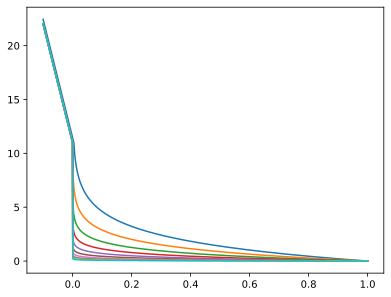

In [7]:

#x = jnp.linspace(10**-10, 1, 10000)
x = jnp.concatenate((jnp.linspace(-0.1,-0.001,10), jnp.logspace(-46,0,1000) ))

t = 0.5
lam = 1.6

for i in range(10):
    plt.plot(x, boundary_fn(x, t, 11, True), '-' )
    t = t * lam
    

#y_log_cont = jnp.log(-x - 0.01 )
#plt.plot(x, y_log_cont, '-k')

# Pendulum example

In [8]:
def solve_pendulum_problem(phi_t = jnp.pi, n_steps = 100):

    controlled_pendulum, pendulum_output, running_cost, terminal_state_eq_constraints, inequ_constraints, theta, x0, dt = problem_def_pendulum()
        
    f = rk4(controlled_pendulum, dt)

    theta = (
        5.0, 
        1.0 * 0.1, 
        0.1,  # wu
        phi_t,
        0.0
    )
    x0 = jnp.array([ jnp.deg2rad(0.0), jnp.deg2rad(100.0), ])

    U_guess = jnp.zeros( (n_steps, 1) )
    X_guess = jnp.vstack((
        jnp.linspace(x0[0], phi_t, n_steps ),
        jnp.linspace(x0[1], 0, n_steps ),
    )).T

    # run
    X_opt, U_opt, _, res = optimize_trajectory(
        f, 
        None,
        terminal_state_eq_constraints, 
        inequ_constraints,
        running_cost, 
        x0, 
        X_guess=X_guess,
        U_guess=U_guess, 
        theta=theta,
#        c_eq_penality = c_eq_penality,
#        opt_t_init = opt_t_init,
        
        #max_iter_boundary_method = 10,
    )
    
    return X_guess, X_opt, U_opt, res



👉 solving problem with n_horizon=50, n_states=2 n_inputs=1
🔄 it=0 	 (sub iter=144) 	 t/t_final = 0 % 	 eq_error/eq_tol = 54252 %
🔄 it=1 	 (sub iter=99) 	 t/t_final = 1 % 	 eq_error/eq_tol = 45339 %
🔄 it=2 	 (sub iter=122) 	 t/t_final = 1 % 	 eq_error/eq_tol = 34663 %
🔄 it=3 	 (sub iter=134) 	 t/t_final = 2 % 	 eq_error/eq_tol = 24541 %
🔄 it=4 	 (sub iter=139) 	 t/t_final = 3 % 	 eq_error/eq_tol = 16385 %
🔄 it=5 	 (sub iter=148) 	 t/t_final = 5 % 	 eq_error/eq_tol = 10506 %
🔄 it=6 	 (sub iter=152) 	 t/t_final = 8 % 	 eq_error/eq_tol = 6945 %
🔄 it=7 	 (sub iter=132) 	 t/t_final = 13 % 	 eq_error/eq_tol = 4385 %
🔄 it=8 	 (sub iter=130) 	 t/t_final = 21 % 	 eq_error/eq_tol = 2690 %
🔄 it=9 	 (sub iter=135) 	 t/t_final = 34 % 	 eq_error/eq_tol = 1628 %
🔄 it=10 	 (sub iter=138) 	 t/t_final = 55 % 	 eq_error/eq_tol = 980 %
🔄 it=11 	 (sub iter=163) 	 t/t_final = 88 % 	 eq_error/eq_tol = 591 %
🔄 it=12 	 (sub iter=119) 	 t/t_final = 100 % 	 eq_error/eq_tol = 369 %
🔄 it=13 	 (sub iter=118) 	 t/t_f

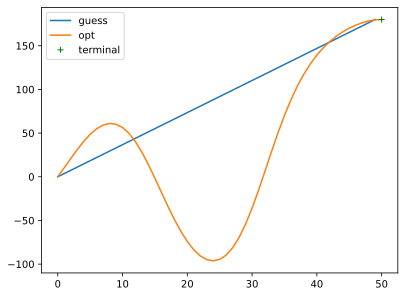

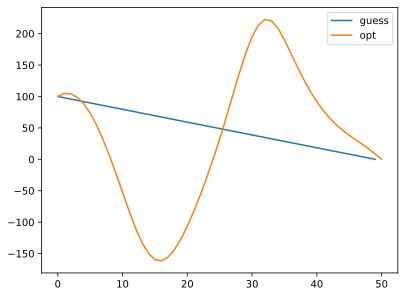

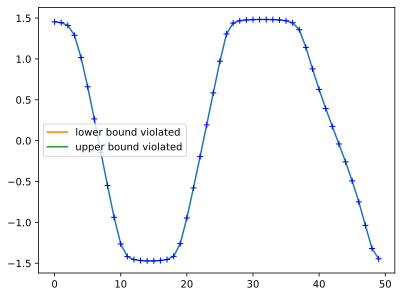

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


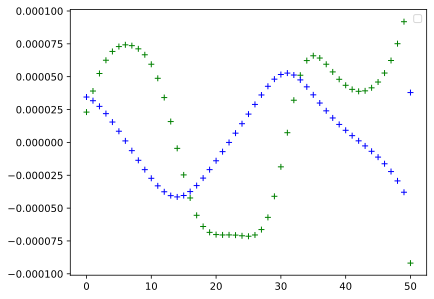

In [9]:
phi_t = jnp.pi / 1
n_steps = 50

X_guess, X_opt, U_opt, res = solve_pendulum_problem(phi_t, n_steps)
is_converged, c_eq, c_ineq, trace, n_iter = unpack_res(res)

plt.plot(jnp.rad2deg( X_guess[:,0] ), label='guess')
plt.plot(jnp.rad2deg( X_opt[:,0]), label='opt' )
plt.plot([n_steps], np.rad2deg( [phi_t] ), '+g', label='terminal' )

plt.legend()
plt.show()

plt.plot(jnp.rad2deg( X_guess[:,1] ), label='guess')
plt.plot(jnp.rad2deg( X_opt[:,1]), label='opt' )
plt.legend()
plt.show()

plt.plot(U_opt)
plt.plot(U_opt, 'b+')
plt.plot(
    jnp.where( c_ineq[0] < 0 , -1.5, math.nan ),
    label='lower bound violated'
)
plt.plot(
    jnp.where( c_ineq[1] < 0 , 1.5, math.nan ),
    label='upper bound violated'
)
plt.legend()
plt.show()

plt.plot(c_eq[:,0], 'g+')
plt.plot(c_eq[:,1], 'b+')
plt.legend()
plt.show()

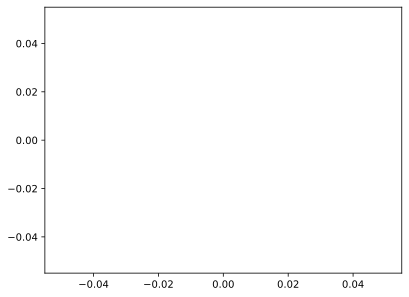

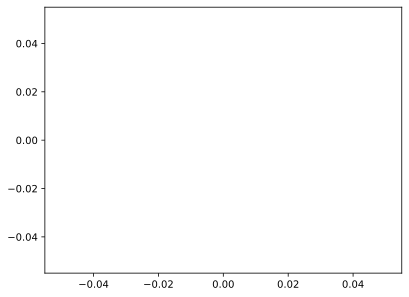

In [10]:
plt.plot(trace[0], '+r', label='eq metric')
plt.plot(trace[1], '+k', label='ineq metric')
plt.show()

plt.plot(jnp.where(trace[2]==-1, math.nan, trace[2]), '+r', label='n_iter_inner')


# Flow model

In [11]:
def make_trajectories(n_steps, P_max_src_1 = 100, P_max_src_2 = 10, balance=0.0):
    P_src_1 = P_max_src_1 * jnp.concatenate(( jnp.zeros(10), jnp.sin( jnp.linspace(0, math.pi, n_steps-20 )), jnp.zeros(10)  ))
    P_src_2 = P_max_src_2 * jnp.concatenate(( jnp.zeros(10), jnp.sin( jnp.linspace(0, math.pi, n_steps-20 )), jnp.zeros(10)  ))
    
    b = jnp.linspace(-balance, balance, n_steps)
    price  = b + jnp.concatenate(( jnp.ones(10), 1-jnp.sin( jnp.linspace(0, math.pi, n_steps-20 )), jnp.ones(10)  ))
    
    return P_src_1, P_src_2, price
    

def problem_def_powerflow(n_steps = 50):
        
    def model(x, u, k, theta):
        
        bat_1, bat_2 = x[0], x[1]
        P_bat_1, P_bat_2 = u[0], u[1]
        
        c_1, c_2, P_src_1, P_src_2, reward = theta['c_1'], theta['c_2'], theta['P_src_1'], theta['P_src_2'], theta['reward']
                
        #
        P_transmission = P_src_1[k] + P_bat_1
        P_yield = P_transmission + P_src_2[k] + P_bat_2
        
        #
        bat_1_dot = 1/c_1 * ( -P_bat_1 )
        bat_2_dot = 1/c_2 * ( -P_bat_2 )
        
        x_dot = jnp.array([
            bat_1_dot, bat_2_dot
        ])
 
        #
        R = reward[k] * P_yield
        J = - 0.01*R
        
        
        deb1 = P_src_2[k]
        deb2 = P_bat_2
                 
        return x_dot, P_transmission, P_yield, J, R, deb1, deb2

    def f(x, u, k, theta):
        x_dot, P_transmission, P_yield, J, R, _, _ = model(x, u, k, theta)
        return x_dot

    def g(x, u, k, theta):
        x_dot, P_transmission, P_yield, J, R, deb1, deb2 = model(x, u, k, theta)
        return P_transmission, P_yield, R, deb1, deb2

    def running_cost(x, u, k, theta):
        
        x_dot, P_transmission, P_yield, J, R, _, _ = model(x, u, k, theta)
        return J
        
    def terminal_state_eq_constraints(x_final, theta):
        bat_1, bat_2 = x_final

        return jnp.array([
            0.2,
            0.1
        ])
    
    def inequ_constraints(x, u, k, theta):
        
        bat_1,   bat_2   = x[:,0], x[:,1]
        P_bat_1, P_bat_2 = u[:,0], u[:,1]
        
        # constraints
        c_ineq = jnp.array([
            constraint_geq( bat_1, 0 ),
            constraint_leq( bat_1, 1 ),
            
            constraint_geq( bat_2, 0 ),
            constraint_leq( bat_2, 1 ),
            
            constraint_geq( P_bat_1, -10 ),
            constraint_leq( P_bat_1,  10 ),
            
            constraint_geq( P_bat_2, -50 ),
            constraint_leq( P_bat_2,  50 ),
        ])
        
        # x_dot, P_transmission, P_yield, J, c_ineq = model(x, u, k, theta)
        return c_ineq
        
    def make_guess(x0, theta):
        U_guess = jnp.zeros( (n_steps, 2) )

        X_guess = jnp.vstack((
            jnp.linspace(x0[0], x0[0], n_steps ),
            jnp.linspace(x0[1], x0[1], n_steps ),
        )).T
        
        return X_guess, U_guess
    
    
    P_src_1, P_src_2, reward = make_trajectories(n_steps, 100, 10)
    
    theta = { 
        'c_1'     : 200, 
        'c_2'     : 2000, 
        'P_src_1' : P_src_1, 
        'P_src_2' : P_src_2,
        'reward'  : reward
    }
    
    c_1_init, c_2_init = 0.5, 0.5
    x0 = jnp.array([ c_1_init, c_2_init ])
    
    #
    f_dscr = rk4(f, dt=1.0)

    return f_dscr, g, running_cost, None, inequ_constraints, theta, x0, make_guess



f_dscr, g, running_cost, terminal_state_eq_constraints, inequ_constraints, theta, x0, make_guess = problem_def_powerflow(n_steps = 50)

In [12]:
X_guess, U_guess = make_guess(x0, theta)

# run
X_opt, U_opt, system_outputs, res = optimize_trajectory(
    f_dscr, 
    g,
    terminal_state_eq_constraints,
    inequ_constraints,
    running_cost,
    x0,
    X_guess=X_guess,
    U_guess=U_guess, 
    theta=theta,
)

is_converged, c_eq, c_ineq, trace, n_iter = unpack_res(res)

👉 solving problem with n_horizon=50, n_states=2 n_inputs=2
🔄 it=0 	 (sub iter=131) 	 t/t_final = 0 % 	 eq_error/eq_tol = 13641 %
🔄 it=1 	 (sub iter=151) 	 t/t_final = 1 % 	 eq_error/eq_tol = 14220 %
🔄 it=2 	 (sub iter=132) 	 t/t_final = 1 % 	 eq_error/eq_tol = 13055 %
🔄 it=3 	 (sub iter=175) 	 t/t_final = 2 % 	 eq_error/eq_tol = 10518 %
🔄 it=4 	 (sub iter=177) 	 t/t_final = 3 % 	 eq_error/eq_tol = 7127 %
🔄 it=5 	 (sub iter=175) 	 t/t_final = 5 % 	 eq_error/eq_tol = 4786 %
🔄 it=6 	 (sub iter=180) 	 t/t_final = 8 % 	 eq_error/eq_tol = 3278 %
🔄 it=7 	 (sub iter=241) 	 t/t_final = 13 % 	 eq_error/eq_tol = 2092 %
🔄 it=8 	 (sub iter=249) 	 t/t_final = 21 % 	 eq_error/eq_tol = 1336 %
🔄 it=9 	 (sub iter=191) 	 t/t_final = 34 % 	 eq_error/eq_tol = 997 %
🔄 it=10 	 (sub iter=222) 	 t/t_final = 55 % 	 eq_error/eq_tol = 587 %
🔄 it=11 	 (sub iter=308) 	 t/t_final = 88 % 	 eq_error/eq_tol = 336 %
🔄 it=12 	 (sub iter=168) 	 t/t_final = 100 % 	 eq_error/eq_tol = 246 %
🔄 it=13 	 (sub iter=231) 	 t/t_fin

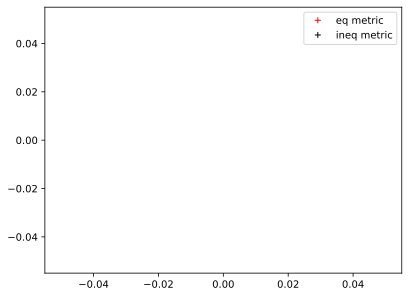

In [13]:
plt.plot(trace[0], '+r', label='eq metric')
plt.plot(trace[1], '+k', label='ineq metric')
plt.legend()

In [14]:
# assertions

assert is_converged

# there shall be no violations of the constraints
assert jnp.where( jnp.abs( c_eq.flatten() > 0.001 ) )[0].shape[0] == 0
assert jnp.where( c_ineq.flatten() < -0.01 )[0].shape[0] == 0

In [15]:
def plot_flow(X_opt, U_opt, system_outputs, theta):

    # prepare data
    P_transmission, P_yield, R, deb1, deb2 = system_outputs # unpack output variable (return of function g)

    _, _, P_src_1, P_src_2, reward = theta['c_1'], theta['c_2'], theta['P_src_1'], theta['P_src_2'], theta['reward']

    P_bat_1, P_bat_2 = U_opt[:,0], U_opt[:,1]
    soc_1, soc_2     = X_opt[:,0], X_opt[:,1]

    # make time vectors
    time  = jnp.linspace(0, soc_1.shape[0]-1, soc_1.shape[0])
    time2 = jnp.linspace(0, P_bat_1.shape[0]-1, P_bat_1.shape[0])

    # Create a figure and two subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(12, 5))

    ax1.plot(P_transmission, label='P_transmission' )
    ax1.plot(P_yield, label='P_yield' )
    ax1.plot(P_src_1, '-', label='P_src_1' )
    ax1.plot(P_src_2, '-', label='P_src_2' )
    ax1.legend()
    ax1.set_ylabel('power')

    ax2.plot(time2, P_bat_1, '-+', label='power bat 1')
    ax2.plot(time2, P_bat_2, '-+',  label='power bat 2')
    ax2.set_ylabel('soc %')
    ax2.legend()

    ax3.plot(time, soc_1, '-+',  label='soc bat 1')
    ax3.plot(time, soc_2, '-+',  label='soc bat 2')
    ax3.set_ylabel('soc %')
    ax3.legend()

    ax4.plot(time2, 100*reward, '-+',  label='100 * price')
    ax4.plot(time2, R, '-+',  label='R')
    ax4.set_ylabel('')
    ax4.legend()

    # Add a title to the entire figure
    fig.suptitle('time series')

    # Show the plot
    plt.show()    

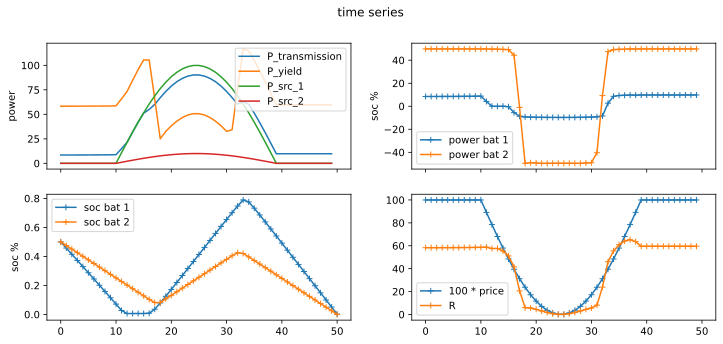

In [16]:
plot_flow(X_opt, U_opt, system_outputs, theta)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


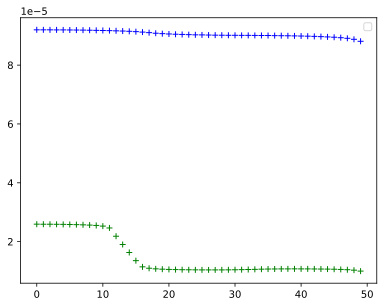

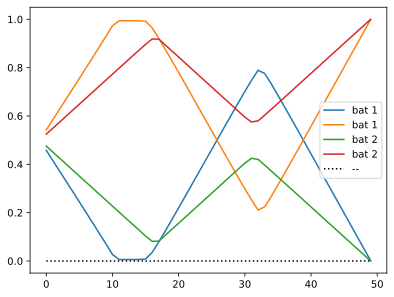

In [17]:
plt.plot(c_eq[:,0], 'g+')
plt.plot(c_eq[:,1], 'b+')
plt.legend()
plt.show()

plt.plot(c_ineq[0,:], label='bat 1')
plt.plot(c_ineq[1,:], label='bat 1')
plt.plot(c_ineq[2,:], label='bat 2')
plt.plot(c_ineq[3,:], label='bat 2')

plt.plot(0 * jnp.ones( (c_ineq.shape[1]) ) , ':k', label='--')

plt.legend()
plt.show()

In [18]:
sliders = {
        'c_1'           : widgets.FloatSlider(min=100, max=400,  step=1.0, value=200,  description='c_1'),
        'c_2'           : widgets.FloatSlider(min=100, max=8000, step=1.0, value=2000, description='c_2'),
        'P_src_1'       : widgets.FloatSlider(min=10, max=100, step=1.0, value=100, description='P_src_1'),
        'P_src_2'       : widgets.FloatSlider(min=1, max=10, step=1.0,   value=10, description='P_src_2'),
        'price_balance' : widgets.FloatSlider(min=-1, max=1, step=0.01, value=0.0, description='price_balance'),
}

solver = Solver( partial(problem_def_powerflow, n_steps = 50) )

def set_theta_fn(solver, c_1, c_2, P_src_1, P_src_2, price_balance):
        solver.theta['c_1'] = c_1
        solver.theta['c_2'] = c_2

        P_src_1_, P_src_2_, price = make_trajectories(solver.n_steps, P_src_1, P_src_2, price_balance)

        solver.theta['P_src_1'] = P_src_1_
        solver.theta['P_src_2'] = P_src_2_
        solver.theta['reward']  = price
        

In [19]:
ui, output_box, print_output, plot_output = manual_investigate( solver, sliders, set_theta_fn, plot_flow )
display(ui, plot_output)

GridBox(children=(FloatSlider(value=200.0, description='c_1', max=400.0, min=100.0, step=1.0), FloatSlider(val…

Output()

In [20]:
display(print_output)

Output()